In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import warnings
warnings.filterwarnings('ignore')
from layers import Linear, Sigmoid, NeuralNetwork  # Results from Seminar 1

In [51]:
data_dir= 'C:\\Users\\Alex\\Downloads\\indoor_outdoor_dataset'
#data_outdore = 'C:\Users\Alex\Downloads\indoor_outdoor_dataset\outdore'

transform = transforms.Compose([
    transforms.Resize((64, 64)),   
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])  
])

full_data = ImageFolder(data_dir, transform=transform)

train_size = int(1*int(0.8 * len(full_data)))
val_size = int(1*int(0.1 * len(full_data)))
test_size = int(1*(len(full_data) - train_size - val_size))
oth=len(full_data)-train_size-test_size-val_size
train_data, val_data, test_data,_ = random_split(full_data, [train_size, val_size, test_size, oth])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [52]:
print(len(train_loader))

10264


In [54]:
writer = SummaryWriter('runs/indoor-outdoor')

In [55]:
def save_checkpoint(state, filename='checkpoint.pth'):
    """Сохранение состояния модели"""
    torch.save(state, filename)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, plot=True):
    best_val_acc = 0.0
    train_loss_epochs = []
    val_loss_epochs = []
    train_accuracy_epochs = []
    val_accuracy_epochs = []
    try:
        for epoch in tqdm(range(num_epochs)):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
                optimizer.zero_grad()        
                outputs = model(inputs)
                loss = criterion(outputs, labels)      
                loss.backward()
                optimizer.step()           
                running_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
            
            train_loss = running_loss / len(train_loader)
            train_acc = correct / total
            val_loss, val_acc = evaluate_model(model, val_loader, criterion)

            train_loss_epochs.append(train_loss)
            train_accuracy_epochs.append(train_acc)
            val_loss_epochs.append(val_loss)
            val_accuracy_epochs.append(val_acc)
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
            
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Accuracy/train', train_acc, epoch)
            writer.add_scalar('Loss/val', val_loss, epoch)
            writer.add_scalar('Accuracy/val', val_acc, epoch)
            
    
            if val_acc > best_val_acc:
                print(f'Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving model...')
                best_val_acc = val_acc
                
                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss,
                    'accuracy': val_acc
                }
                save_checkpoint(checkpoint, 'cnn_best_checkpoint.pth')
        if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(val_loss_epochs, label='Val')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(val_accuracy_epochs, label='Val accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss, \
           val_loss, \
           train_acc, \
           val_acc
            
    
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(loader)
    accuracy = correct / total
    print("accuracy=", accuracy)
    return loss, accuracy

 10%|███████▉                                                                       | 1/10 [32:18<4:50:50, 1938.98s/it]

accuracy= 0.8888726493228101
Epoch [1/10], Loss: 0.3353, Accuracy: 0.8589, Val Loss: 0.2715, Val Accuracy: 0.8889
Validation accuracy improved from 0.0000 to 0.8889. Saving model...


 20%|███████████████▍                                                             | 2/10 [1:04:42<4:18:55, 1941.88s/it]

accuracy= 0.9022702913378154
Epoch [2/10], Loss: 0.2687, Accuracy: 0.8931, Val Loss: 0.2453, Val Accuracy: 0.9023
Validation accuracy improved from 0.8889 to 0.9023. Saving model...


 30%|███████████████████████                                                      | 3/10 [1:37:11<3:46:55, 1945.03s/it]

accuracy= 0.9039754457760889
Epoch [3/10], Loss: 0.2443, Accuracy: 0.9041, Val Loss: 0.2427, Val Accuracy: 0.9040
Validation accuracy improved from 0.9023 to 0.9040. Saving model...


 40%|██████████████████████████████▊                                              | 4/10 [2:09:44<3:14:49, 1948.20s/it]

accuracy= 0.9106255480853551
Epoch [4/10], Loss: 0.2301, Accuracy: 0.9100, Val Loss: 0.2370, Val Accuracy: 0.9106
Validation accuracy improved from 0.9040 to 0.9106. Saving model...


 50%|██████████████████████████████████████▌                                      | 5/10 [2:41:56<2:41:52, 1942.42s/it]

accuracy= 0.9171294942999123
Epoch [5/10], Loss: 0.2204, Accuracy: 0.9145, Val Loss: 0.2162, Val Accuracy: 0.9171
Validation accuracy improved from 0.9106 to 0.9171. Saving model...


 60%|██████████████████████████████████████████████▏                              | 6/10 [3:14:10<2:09:18, 1939.57s/it]

accuracy= 0.9167397447140212
Epoch [6/10], Loss: 0.2131, Accuracy: 0.9177, Val Loss: 0.2170, Val Accuracy: 0.9167


 70%|█████████████████████████████████████████████████████▉                       | 7/10 [3:46:36<1:37:04, 1941.60s/it]

accuracy= 0.9166179479684303
Epoch [7/10], Loss: 0.2061, Accuracy: 0.9206, Val Loss: 0.2148, Val Accuracy: 0.9166


 80%|█████████████████████████████████████████████████████████████▌               | 8/10 [4:18:39<1:04:31, 1935.60s/it]

accuracy= 0.9210757088570594
Epoch [8/10], Loss: 0.2009, Accuracy: 0.9226, Val Loss: 0.2055, Val Accuracy: 0.9211
Validation accuracy improved from 0.9171 to 0.9211. Saving model...


 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [4:50:45<32:12, 1932.54s/it]

accuracy= 0.9209295527623502
Epoch [9/10], Loss: 0.1955, Accuracy: 0.9249, Val Loss: 0.2032, Val Accuracy: 0.9209


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [5:22:52<00:00, 1937.26s/it]

accuracy= 0.9211975056026503
Epoch [10/10], Loss: 0.1915, Accuracy: 0.9266, Val Loss: 0.2047, Val Accuracy: 0.9212
Validation accuracy improved from 0.9211 to 0.9212. Saving model...


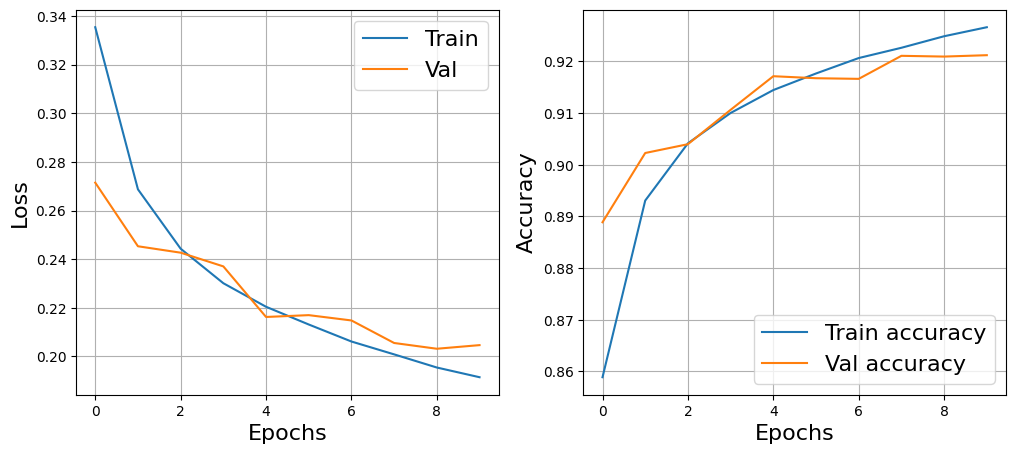

accuracy= 0.9188122670693981


(0.20609368899124308, 0.9188122670693981)

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expansion_factor):
        super(MBConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.expansion_factor = expansion_factor

        self.conv1 = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels * expansion_factor)
        self.conv2 = nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=kernel_size, stride=stride, padding=(kernel_size - 1) // 2, groups=in_channels * expansion_factor, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels * expansion_factor)
        self.conv3 = nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU6()

    def forward(self, x):
        iden=x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        if self.in_channels == self.out_channels and self.stride == 1:
            x = x + ident
        return x

class EfficientNet(nn.Module):
    def __init__(self, num_classes=1, width_coefficient=1.1, depth_coefficient=1.2, dropout_rate=0.3):
        super(EfficientNet, self).__init__()
        self.num_classes = num_classes
        self.width_coefficient = width_coefficient
        self.depth_coefficient = depth_coefficient
        self.dropout_rate = dropout_rate

        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6()
        )

        self.blocks = nn.ModuleList([
            MBConvBlock(32, 16, 3, 1, 1),
            MBConvBlock(16, 24, 3, 2, 6),
            MBConvBlock(24, 40, 5, 2, 6),
            MBConvBlock(40, 80, 3, 2, 6),
            MBConvBlock(80, 112, 5, 1, 6),
            MBConvBlock(112, 192, 5, 2, 6),
            MBConvBlock(192, 320, 3, 1, 6)
        ])

        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(1280, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.stem(x)
        for block in self.blocks:
            x = block(x)
        x = self.head(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=EfficientNet().to(device)
cost=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())
train_model(model, train_loader, val_loader, cost,optimizer, num_epochs=10)
evaluate_model(model,test_loader,cost)

In [59]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Количество обучаемых параметров: {num_params}")

Количество обучаемых параметров: 1402945


In [63]:
from sklearn.metrics import f1_score

def evaluate_model2(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            loss = criterion(predicted, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(loader)
    accuracy = correct / total
    print("f1=", accuracy)
    return loss, accuracy
    
evaluate_model2(model,test_loader,f1_score)

f1= 0.9188122670693981


(0.9097266101380462, 0.9188122670693981)

Что помогло: 
1) Добавление слоев с Skip-connection, как метод борьбы с затухающим градиентом;
2) Compound scaling, который пропорционально масштабирует ширину, глубину и разрешение сети;
3) Регуляризация в виде Dropot и BatchNorm;
4) Свертки 1 на 1 для уменьшения/увеличения размерности(числа каналов)

## Менее эффективные модели ( ResNet, VGG, AlexNet, LeNet)

In [37]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        
        self.shortcut = nn.Sequential() # Слой для изменения размерности входа (если необходимо)
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.GELU(),
                        nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
        
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512,1),
            nn.Sigmoid())

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2])


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=ResNet18().to(device)
cost=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())
train_model(model, train_loader, val_loader, cost,optimizer, num_epochs=20)
evaluate_model(model,test_loader,cost)

  5%|████                                                                            | 1/20 [03:42<1:10:34, 222.86s/it]

accuracy= 0.8114035087719298
Epoch [1/20], Loss: 0.5118, Accuracy: 0.7629, Val Loss: 0.4551, Val Accuracy: 0.8114


 10%|████████                                                                        | 2/20 [07:27<1:07:14, 224.13s/it]

accuracy= 0.7943469785575049
Epoch [2/20], Loss: 0.4580, Accuracy: 0.7963, Val Loss: 0.4658, Val Accuracy: 0.7943


 15%|████████████                                                                    | 3/20 [11:06<1:02:45, 221.48s/it]

accuracy= 0.7811890838206628
Epoch [3/20], Loss: 0.4332, Accuracy: 0.8091, Val Loss: 0.4533, Val Accuracy: 0.7812


 20%|████████████████▍                                                                 | 4/20 [14:40<58:19, 218.75s/it]

accuracy= 0.8347953216374269
Epoch [4/20], Loss: 0.4172, Accuracy: 0.8181, Val Loss: 0.3809, Val Accuracy: 0.8348


 25%|████████████████████▌                                                             | 5/20 [18:14<54:13, 216.92s/it]

accuracy= 0.7953216374269005
Epoch [5/20], Loss: 0.4093, Accuracy: 0.8265, Val Loss: 0.4570, Val Accuracy: 0.7953


 30%|████████████████████████▌                                                         | 6/20 [21:48<50:22, 215.91s/it]

accuracy= 0.8284600389863548
Epoch [6/20], Loss: 0.4081, Accuracy: 0.8242, Val Loss: 0.3869, Val Accuracy: 0.8285


 35%|████████████████████████████▋                                                     | 7/20 [25:22<46:37, 215.18s/it]

accuracy= 0.830896686159844
Epoch [7/20], Loss: 0.3784, Accuracy: 0.8413, Val Loss: 0.3848, Val Accuracy: 0.8309


 40%|████████████████████████████████▊                                                 | 8/20 [29:00<43:15, 216.26s/it]

accuracy= 0.854775828460039
Epoch [8/20], Loss: 0.3666, Accuracy: 0.8442, Val Loss: 0.3551, Val Accuracy: 0.8548


 45%|████████████████████████████████████▉                                             | 9/20 [32:39<39:48, 217.13s/it]

accuracy= 0.8518518518518519
Epoch [9/20], Loss: 0.3564, Accuracy: 0.8484, Val Loss: 0.3644, Val Accuracy: 0.8519


 50%|████████████████████████████████████████▌                                        | 10/20 [36:14<36:03, 216.38s/it]

accuracy= 0.8460038986354775
Epoch [10/20], Loss: 0.3364, Accuracy: 0.8583, Val Loss: 0.3875, Val Accuracy: 0.8460


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:48<32:19, 215.54s/it]

accuracy= 0.8430799220272904
Epoch [11/20], Loss: 0.3271, Accuracy: 0.8656, Val Loss: 0.3765, Val Accuracy: 0.8431


 55%|████████████████████████████████████████████▌                                    | 11/20 [39:58<32:42, 218.03s/it]


KeyboardInterrupt: 

In [36]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        self.l1=nn.Sequential(
            nn.Conv2d(3,64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.l2=nn.Sequential(
            nn.Conv2d(64,64, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.l3=nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.l4=nn.Sequential(
            nn.Conv2d(128,128, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.l5=nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.l6=nn.Sequential(
            nn.Conv2d(256,256, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.l7=nn.Sequential(
            nn.Conv2d(256,256, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.l8=nn.Sequential(
            nn.Conv2d(256,512, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()) 
        self.l9=nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.l10=nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.l11=nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.l12=nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.l13=nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))


        
        self.fc1=nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 4096),
            nn.ReLU())
        self.fc2=nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc3=nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid())
        
    def forward(self,X):
        out=self.l1(X)
        out=self.l2(out)
        out=self.l3(out)
        out=self.l4(out)
        out=self.l5(out)
        out=self.l6(out)
        out=self.l7(out)
        out=self.l8(out)
        out=self.l9(out)
        out=self.l10(out)
        out=self.l11(out)
        out=self.l12(out)
        out=self.l13(out)
        out=out.view(out.size(0), -1)
        out=self.fc1(out)
        out=self.fc2(out)
        out=self.fc3(out)
        return out
        

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=VGG().to(device)
cost=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())
train_model(model, train_loader, val_loader, cost,optimizer)
evaluate_model(model,test_loader,cost)

 10%|████████▏                                                                         | 1/10 [05:20<48:00, 320.01s/it]

accuracy= 0.524
Epoch [1/10], Loss: 0.7715, Accuracy: 0.5263, Val Loss: 0.6618, Val Accuracy: 0.5240


 20%|████████████████▍                                                                 | 2/10 [10:49<43:23, 325.41s/it]

accuracy= 0.69
Epoch [2/10], Loss: 0.6256, Accuracy: 0.6541, Val Loss: 0.6397, Val Accuracy: 0.6900


 30%|████████████████████████▌                                                         | 3/10 [16:21<38:19, 328.49s/it]

accuracy= 0.798
Epoch [3/10], Loss: 0.5198, Accuracy: 0.7631, Val Loss: 0.4296, Val Accuracy: 0.7980


 40%|████████████████████████████████▊                                                 | 4/10 [21:55<33:04, 330.78s/it]

accuracy= 0.792
Epoch [4/10], Loss: 0.4944, Accuracy: 0.7692, Val Loss: 0.4227, Val Accuracy: 0.7920


 50%|█████████████████████████████████████████                                         | 5/10 [27:14<27:12, 326.60s/it]

accuracy= 0.824
Epoch [5/10], Loss: 0.4706, Accuracy: 0.7871, Val Loss: 0.3898, Val Accuracy: 0.8240


 60%|█████████████████████████████████████████████████▏                                | 6/10 [32:41<21:46, 326.69s/it]

accuracy= 0.82
Epoch [6/10], Loss: 0.4438, Accuracy: 0.8108, Val Loss: 0.4101, Val Accuracy: 0.8200


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [38:30<16:42, 334.04s/it]

accuracy= 0.822
Epoch [7/10], Loss: 0.4179, Accuracy: 0.8159, Val Loss: 0.4151, Val Accuracy: 0.8220


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [44:15<11:14, 337.34s/it]

accuracy= 0.836
Epoch [8/10], Loss: 0.3995, Accuracy: 0.8310, Val Loss: 0.3650, Val Accuracy: 0.8360


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [49:56<05:38, 338.67s/it]

accuracy= 0.842
Epoch [9/10], Loss: 0.3679, Accuracy: 0.8434, Val Loss: 0.3487, Val Accuracy: 0.8420


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [55:57<00:00, 335.74s/it]

accuracy= 0.85
Epoch [10/10], Loss: 0.3548, Accuracy: 0.8519, Val Loss: 0.3673, Val Accuracy: 0.8500


accuracy= 0.835


(0.39891161923370666, 0.835)

In [33]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.l1=nn.Sequential(
            nn.Conv2d(3,96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.l2=nn.Sequential(
            nn.Conv2d(96,256, kernel_size=5,stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.l3=nn.Sequential(
            nn.Conv2d(256,384, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.l4=nn.Sequential(
            nn.Conv2d(384,384, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.l5=nn.Sequential(
            nn.Conv2d(384,256, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
            
        self.fc1=nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 4096),
            nn.ReLU())
        self.fc2=nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc3=nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid())
        
    def forward(self,X):
        out=self.l1(X)
        out=self.l2(out)
        out=self.l3(out)
        out=self.l4(out)
        out=self.l5(out)
        out=out.view(out.size(0), -1)
        out=self.fc1(out)
        out=self.fc2(out)
        out=self.fc3(out)
        return out
        

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=AlexNet().to(device)
cost=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())
train_model(model, train_loader, val_loader, cost,optimizer)
evaluate_model(model,test_loader,cost)

 10%|████████▏                                                                         | 1/10 [01:43<15:35, 103.94s/it]

accuracy= 0.75
Epoch [1/10], Loss: 0.5747, Accuracy: 0.7226, Val Loss: 0.5074, Val Accuracy: 0.7500


 20%|████████████████▍                                                                 | 2/10 [03:27<13:47, 103.44s/it]

accuracy= 0.77
Epoch [2/10], Loss: 0.5103, Accuracy: 0.7649, Val Loss: 0.4668, Val Accuracy: 0.7700


 30%|████████████████████████▌                                                         | 3/10 [05:07<11:53, 101.90s/it]

accuracy= 0.804
Epoch [3/10], Loss: 0.4804, Accuracy: 0.7834, Val Loss: 0.4375, Val Accuracy: 0.8040


 40%|█████████████████████████████████▏                                                 | 4/10 [06:42<09:54, 99.15s/it]

accuracy= 0.834
Epoch [4/10], Loss: 0.4586, Accuracy: 0.7963, Val Loss: 0.4303, Val Accuracy: 0.8340


 50%|█████████████████████████████████████████▌                                         | 5/10 [08:13<08:02, 96.49s/it]

accuracy= 0.822
Epoch [5/10], Loss: 0.4467, Accuracy: 0.8042, Val Loss: 0.4058, Val Accuracy: 0.8220


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [09:46<06:20, 95.19s/it]

accuracy= 0.83
Epoch [6/10], Loss: 0.4266, Accuracy: 0.8056, Val Loss: 0.3967, Val Accuracy: 0.8300


 70%|██████████████████████████████████████████████████████████                         | 7/10 [11:20<04:44, 94.93s/it]

accuracy= 0.802
Epoch [7/10], Loss: 0.4130, Accuracy: 0.8196, Val Loss: 0.4109, Val Accuracy: 0.8020


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [12:55<03:09, 94.90s/it]

accuracy= 0.766
Epoch [8/10], Loss: 0.3831, Accuracy: 0.8306, Val Loss: 0.5797, Val Accuracy: 0.7660


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [14:29<01:34, 94.61s/it]

accuracy= 0.818
Epoch [9/10], Loss: 0.3752, Accuracy: 0.8404, Val Loss: 0.3938, Val Accuracy: 0.8180


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [16:03<00:00, 96.37s/it]

accuracy= 0.802
Epoch [10/10], Loss: 0.3557, Accuracy: 0.8497, Val Loss: 0.4668, Val Accuracy: 0.8020


accuracy= 0.813


(0.4461446972120376, 0.813)

In [23]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.l1=nn.Sequential(
            nn.Conv2d(3,6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.l2=nn.Sequential(
            nn.Conv2d(6,16, kernel_size=5,stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        self.fc=nn.Sequential(
            nn.Linear(16*13*13, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84,1),
            nn.Sigmoid())
    def forward(self,X):
        out=self.l1(X)
        out=self.l2(out)
        out=out.view(out.size(0), -1)
        out=self.fc(out)
        return out
        

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=LeNet().to(device)
cost=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters())
train_model(model, train_loader, val_loader, cost,optimizer)
evaluate_model(model,test_loader,cost)

 10%|████████▎                                                                          | 1/10 [01:21<12:16, 81.84s/it]

accuracy= 0.802
Epoch [1/10], Loss: 0.5065, Accuracy: 0.7484, Val Loss: 0.4195, Val Accuracy: 0.8020


 20%|████████████████▌                                                                  | 2/10 [01:41<06:02, 45.26s/it]

accuracy= 0.822
Epoch [2/10], Loss: 0.4534, Accuracy: 0.7920, Val Loss: 0.3966, Val Accuracy: 0.8220


 30%|████████████████████████▉                                                          | 3/10 [02:00<03:54, 33.47s/it]

accuracy= 0.81
Epoch [3/10], Loss: 0.4336, Accuracy: 0.8027, Val Loss: 0.3936, Val Accuracy: 0.8100


 40%|█████████████████████████████████▏                                                 | 4/10 [02:20<02:47, 27.95s/it]

accuracy= 0.82
Epoch [4/10], Loss: 0.4162, Accuracy: 0.8109, Val Loss: 0.4000, Val Accuracy: 0.8200


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:39<02:04, 24.88s/it]

accuracy= 0.82
Epoch [5/10], Loss: 0.4111, Accuracy: 0.8152, Val Loss: 0.4063, Val Accuracy: 0.8200


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:59<01:32, 23.00s/it]

accuracy= 0.82
Epoch [6/10], Loss: 0.3867, Accuracy: 0.8268, Val Loss: 0.3977, Val Accuracy: 0.8200


 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:18<01:05, 21.82s/it]

accuracy= 0.842
Epoch [7/10], Loss: 0.3767, Accuracy: 0.8340, Val Loss: 0.3637, Val Accuracy: 0.8420


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:37<00:42, 21.02s/it]

accuracy= 0.782
Epoch [8/10], Loss: 0.3611, Accuracy: 0.8448, Val Loss: 0.4891, Val Accuracy: 0.7820


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:57<00:20, 20.53s/it]

accuracy= 0.816
Epoch [9/10], Loss: 0.3447, Accuracy: 0.8497, Val Loss: 0.4085, Val Accuracy: 0.8160


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:16<00:00, 25.68s/it]

accuracy= 0.818
Epoch [10/10], Loss: 0.3257, Accuracy: 0.8614, Val Loss: 0.3944, Val Accuracy: 0.8180


accuracy= 0.8245


(0.4173242035839293, 0.8245)

  4%|███▎                                                                               | 1/25 [01:04<25:47, 64.49s/it]

accuracy= 0.7222222222222222
Epoch [1/25], Loss: 0.5675, Accuracy: 0.7101, Val Loss: 0.5464, Val Accuracy: 0.7222


  8%|██████▋                                                                            | 2/25 [01:45<19:23, 50.60s/it]

accuracy= 0.7631578947368421
Epoch [2/25], Loss: 0.5077, Accuracy: 0.7586, Val Loss: 0.4919, Val Accuracy: 0.7632


 12%|█████████▉                                                                         | 3/25 [02:26<16:55, 46.17s/it]

accuracy= 0.7850877192982456
Epoch [3/25], Loss: 0.4647, Accuracy: 0.7892, Val Loss: 0.4573, Val Accuracy: 0.7851


 16%|█████████████▎                                                                     | 4/25 [03:07<15:29, 44.24s/it]

accuracy= 0.7811890838206628
Epoch [4/25], Loss: 0.4584, Accuracy: 0.7985, Val Loss: 0.4659, Val Accuracy: 0.7812


 20%|████████████████▌                                                                  | 5/25 [03:48<14:20, 43.00s/it]

accuracy= 0.8036062378167641
Epoch [5/25], Loss: 0.4316, Accuracy: 0.8091, Val Loss: 0.4570, Val Accuracy: 0.8036


 24%|███████████████████▉                                                               | 6/25 [04:29<13:23, 42.29s/it]

accuracy= 0.8084795321637427
Epoch [6/25], Loss: 0.4226, Accuracy: 0.8165, Val Loss: 0.4280, Val Accuracy: 0.8085


 28%|███████████████████████▏                                                           | 7/25 [05:10<12:33, 41.85s/it]

accuracy= 0.8021442495126706
Epoch [7/25], Loss: 0.4184, Accuracy: 0.8160, Val Loss: 0.4360, Val Accuracy: 0.8021


 32%|██████████████████████████▌                                                        | 8/25 [05:50<11:41, 41.29s/it]

accuracy= 0.8001949317738791
Epoch [8/25], Loss: 0.4099, Accuracy: 0.8207, Val Loss: 0.4598, Val Accuracy: 0.8002


 36%|█████████████████████████████▉                                                     | 9/25 [06:30<10:55, 40.96s/it]

accuracy= 0.8172514619883041
Epoch [9/25], Loss: 0.4007, Accuracy: 0.8261, Val Loss: 0.4279, Val Accuracy: 0.8173


 40%|████████████████████████████████▊                                                 | 10/25 [07:11<10:14, 41.00s/it]

accuracy= 0.8118908382066277
Epoch [10/25], Loss: 0.3964, Accuracy: 0.8294, Val Loss: 0.4233, Val Accuracy: 0.8119


 44%|██████████████████████████████████▊                                            | 11/25 [36:14<2:11:05, 561.85s/it]

accuracy= 0.8104288499025342
Epoch [11/25], Loss: 0.3981, Accuracy: 0.8240, Val Loss: 0.4206, Val Accuracy: 0.8104


 48%|█████████████████████████████████████▉                                         | 12/25 [36:55<1:27:23, 403.38s/it]

accuracy= 0.8104288499025342
Epoch [12/25], Loss: 0.3867, Accuracy: 0.8334, Val Loss: 0.4096, Val Accuracy: 0.8104


 52%|██████████████████████████████████████████                                       | 13/25 [37:36<58:42, 293.52s/it]

accuracy= 0.7889863547758285
Epoch [13/25], Loss: 0.3814, Accuracy: 0.8318, Val Loss: 0.4817, Val Accuracy: 0.7890


 56%|█████████████████████████████████████████████▎                                   | 14/25 [38:18<39:54, 217.67s/it]

accuracy= 0.8109161793372319
Epoch [14/25], Loss: 0.3738, Accuracy: 0.8403, Val Loss: 0.4458, Val Accuracy: 0.8109


 60%|████████████████████████████████████████████████▌                                | 15/25 [38:59<27:25, 164.51s/it]

accuracy= 0.8201754385964912
Epoch [15/25], Loss: 0.3655, Accuracy: 0.8428, Val Loss: 0.4272, Val Accuracy: 0.8202


 64%|███████████████████████████████████████████████████▊                             | 16/25 [39:40<19:05, 127.32s/it]

accuracy= 0.8079922027290448
Epoch [16/25], Loss: 0.3608, Accuracy: 0.8476, Val Loss: 0.5037, Val Accuracy: 0.8080


 68%|███████████████████████████████████████████████████████                          | 17/25 [40:21<13:30, 101.28s/it]

accuracy= 0.8114035087719298
Epoch [17/25], Loss: 0.3594, Accuracy: 0.8460, Val Loss: 0.5024, Val Accuracy: 0.8114


 72%|███████████████████████████████████████████████████████████                       | 18/25 [41:01<09:40, 82.96s/it]

accuracy= 0.8109161793372319
Epoch [18/25], Loss: 0.3512, Accuracy: 0.8501, Val Loss: 0.4372, Val Accuracy: 0.8109


 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [41:42<07:02, 70.34s/it]

accuracy= 0.8138401559454191
Epoch [19/25], Loss: 0.3324, Accuracy: 0.8585, Val Loss: 0.5754, Val Accuracy: 0.8138


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [42:23<05:07, 61.48s/it]

accuracy= 0.7982456140350878
Epoch [20/25], Loss: 0.3265, Accuracy: 0.8600, Val Loss: 0.5549, Val Accuracy: 0.7982


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [43:04<03:41, 55.38s/it]

accuracy= 0.8065302144249513
Epoch [21/25], Loss: 0.3140, Accuracy: 0.8684, Val Loss: 0.5378, Val Accuracy: 0.8065


 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [43:45<02:33, 51.02s/it]

accuracy= 0.8089668615984406
Epoch [22/25], Loss: 0.3132, Accuracy: 0.8674, Val Loss: 0.5823, Val Accuracy: 0.8090


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [44:26<01:35, 47.93s/it]

accuracy= 0.8055555555555556
Epoch [23/25], Loss: 0.2947, Accuracy: 0.8785, Val Loss: 0.5646, Val Accuracy: 0.8056


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [45:06<00:45, 45.66s/it]

accuracy= 0.8045808966861598
Epoch [24/25], Loss: 0.2813, Accuracy: 0.8812, Val Loss: 0.5416, Val Accuracy: 0.8046


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [45:46<00:00, 109.87s/it]

accuracy= 0.7962962962962963
Epoch [25/25], Loss: 0.2920, Accuracy: 0.8811, Val Loss: 0.5143, Val Accuracy: 0.7963


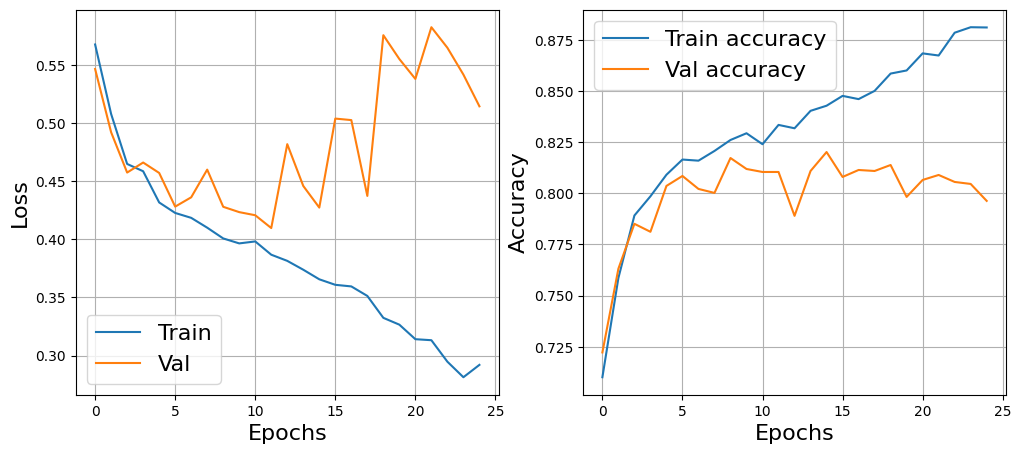

accuracy= 0.8051729415365779


(0.5707374665077903, 0.8051729415365779)

In [35]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1), #3 - входные каналы, 32 - выходные
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(12, 20, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(20, 30, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(30 * 8 * 8, 512), #64:2^3 =8
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


model = CNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)
evaluate_model(model,test_loader,criterion)

## Реализация CNN без nn.Module

In [130]:
def make_pad(X, p):
    X_pad = np.pad(X, ((0, 0), (p, p), (p, p), (0, 0)), 'constant', constant_values=(0, 0))
    return X_pad
    
class ReLU:
    def __init__(self):
        pass
    def forward(self, X):
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

class Conv2D:

    def __init__(self, input_channels, filters, filter_size=3, padding=1, stride=1,learning_rate=0.001, optimizer=None):
        self.filters = filters
        self.filter_size = filter_size
        self.input_channels = input_channels
        self.padding = padding
        self.stride = stride
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.cache = None
        self.not_first = False
        

    def forward(self, X_prev):
        activation_caches = []
        
        if self.not_first == False:
            self.W = np.random.randn(self.filter_size, self.filter_size, X_prev.shape[-1], self.filters) 
            self.b = np.random.randn(1, 1, 1, self.filters)
            self.not_first = True
        
        (m, height_prev, wide_prev, channels_prev) = X_prev.shape
        (f, f, channels_prev, channels) = self.W.shape

        height = int((height_prev - f + (2 * self.padding)) / self.stride) + 1
        wide = int((wide_prev - f + (2 * self.padding)) / self.stride) + 1
        
        output = np.zeros((m, height, wide, channels))
        X_pp = make_pad(X_prev, self.padding)
       
        for i in range(m):
            xpp = X_pp[i]  
            
            for h in range(height):                 
                string1 = h * self.stride
                string2 = string1 + f
                
                for w in range(wide):                  
                    row1 = w * self.stride
                    row2 = row1 + f
                   
                    for c in range(channels):  
                        window = xpp[string1:string2, row1:row2, :]                        
                        weights = self.W[:, :, :, c]
                        biases = self.b[:, :, :, c] 
                        output[i, h, w, c] = np.sum(np.multiply(window, weights))+ float(biases)
               
                output[i], activation_cache = np.maximum(0,output[i]), output[i]
                activation_caches.append(activation_cache)
        
        self.cache = (X_prev, np.array(activation_caches))
        return output

    def backward(self, dZ):
        X, activation_cache = self.cache
        W, b = self.W, self.b
        (m, height_prev, wide_prev, channels_prev) = X.shape
        (f, f, channels_prev, channels) = W.shape
    
        stride = self.stride
        pad = self.padding
        (m, height, wide, channels) = dZ.shape

        dX = np.zeros((m, height_prev, wide_prev, channels_prev))                           
        self.dW = np.zeros((f, f, channels_prev, channels))
        self.db = np.zeros((1, 1, 1, channels))

        X_p = make_pad(X, pad)
        dX_p = make_pad(dX, pad)
        
        for i in range(m):
            temp = np.array(dZ[i], copy=True) 
            temp[activation_cache[i] <= 0] = 0
            dZ[i] = temp
            xpp = X_p[i]
            dxpp = dX_p[i]
            
            for h in range(height):   
                string1 = h * stride
                string2 = string1 + f
                
                for w in range(wide):               
                    row1 = w * stride
                    row2 = row1 + f
                    
                    for c in range(channels):          
                        window = xpp[string1:string2, row1:row2, :]
                        dxpp[string1:string2, row1:row2, :] += W[:,:,:,c] * dZ[i, h, w, c]
                        self.dW[:,:,:,c] += window * dZ[i, h, w, c]
                        self.db[:,:,:,c] += dZ[i, h, w, c]
                        
            if pad:
                dX[i, :, :, :] = dxpp[pad:-pad, pad:-pad, :]
            else:
                dX[i, :, :, :] = dA_prev[i, :, :, :]
        return dX

    
    def step(self,_): 
        if self.optimizer == 'adam':
            self.Adam()
        else:   
            self.W = self.W - self.learning_rate * self.dW 
            self.b = self.b - self.learning_rate * self.db 

    
    def Adam(self, beta1=0.9, beta2=0.999):
        self.epsilon = 1e-8
        self.v_dW = np.zeros(self.W.shape)
        self.v_db = np.zeros(self.b.shape)
        self.s_dW = np.zeros(self.W.shape)
        self.s_db = np.zeros(self.b.shape)
        self.t = 1

        self.v_dW = beta1 * self.v_dW + (1-beta1) * self.dW
        self.v_db = beta1 * self.v_db + (1-beta1) * self.db
        self.v_dW_corrected = self.v_dW / (1-beta1**self.t)
        self.v_db_corrected = self.v_db / (1-beta1**self.t)

        self.s_dW = beta2 * self.s_dW + (1-beta2) * np.square(self.dW)
        self.s_db = beta2 * self.s_db + (1-beta2) * np.square(self.db)
        self.s_dW_corrected = self.s_dW / (1-beta2**self.t)
        self.s_db_corrected = self.s_db / (1-beta2**self.t)

        self.t += 1

        self.W = self.W - self.learning_rate * (self.v_dW_corrected / (np.sqrt(self.s_dW_corrected) + self.epsilon))
        self.b = self.b - self.learning_rate * (self.v_db_corrected / (np.sqrt(self.s_db_corrected) + self.epsilon))
        
        

In [131]:
class CE: #Функция потерь - бинарная кросс-энтропия
    def __init__(self): 
        pass
    def forward(self, X, y):
        self.X=X
        self.y=y
        return - np.mean(self.y * np.log(self.X + 1e-7))  
    def backward(self ):
        return -self.y[:, np.newaxis]/(self.X + 1e-7)

In [132]:
class Flatten:
    def __init__(self):
        self.input_shape = None
        
    def forward(self, X):
        self.input_shape = X.shape
        return X.reshape(X.shape[0], -1)
    
    def backward(self, dout):
        return dout.reshape(self.input_shape)
    def step(self, _):
        pass

In [134]:
def train(network, epochs, learning_rate, plot=True, verbose=True, loss=None):   #функция из ДЗ2
    loss = loss or CE()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(-1, 128,128,3).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(-1, 128,128,3).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [ ]:
network = NeuralNetwork([
    Conv2D(input_channels=3,filters=5), Flatten(),
    #Conv2D(input_channels=5,filters=10, 100), ReLU(),
    Linear(5*128*128, 20),ReLU(),
    Linear(20, 1)
])
loss = CE()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 10, 0.01, plot=True, verbose=True)